In [ ]:
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt 
from keras.layers import Concatenate
from keras.models import Model
from keras import layers
from keras.layers import Activation,Dense,Input,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image

In [ ]:
# REFERENCED FROM https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py

In [ ]:
num_classes=100

In [ ]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
x_shape = x_train[0].shape

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1),name=None):
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding,use_bias=False)(x)
    x = Activation('elu')(x)
    x = Dropout(0.1)(x)
    return x

def InceptionV2(input_shape = (32, 32, 3), classes = 100):
    X_Input = tf.keras.Input(input_shape)
    
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    x = conv2d_bn(X_Input,32,3,3,strides=(2,2),padding='valid')
    x = conv2d_bn(x,32,3,3,strides=(1,1),padding='valid')
    x = conv2d_bn(x,64,3,3)
    x = MaxPooling2D((3,3),strides=(2,2))(x)

    x = conv2d_bn(x,80,1,1,padding='valid')
    x = conv2d_bn(x,192,3,3,padding='valid')
    x = MaxPooling2D((3,3),strides=(2,2))(x)

    # (Inception Layer1) * 3 Times
    
    #Inception Layer1 #mixed0
    branch1_1 = conv2d_bn(x,64,1,1)
    
    branch5_5 = conv2d_bn(x,48,1,1)
    branch5_5 = conv2d_bn(branch5_5,64,3,3)

    branch3_3dbl = conv2d_bn(x,64,1,1)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,32,1,1)

    x = layers.concatenate([branch1_1,branch5_5,branch3_3dbl,branch_pool],axis=channel_axis,name='InceptionLayer1')

    #Inception Layer2
    branch1_1 = conv2d_bn(x,64,1,1)
    
    branch5_5 = conv2d_bn(x,48,1,1)
    branch5_5 = conv2d_bn(branch5_5,64,3,3)

    branch3_3dbl = conv2d_bn(x,64,1,1)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,64,1,1)

    x = layers.concatenate([branch1_1,branch5_5,branch3_3dbl,branch_pool],axis=channel_axis,name='InceptionLayer2')

    #Inception Layer3
    branch1_1 = conv2d_bn(x,64,1,1)
    
    branch5_5 = conv2d_bn(x,48,1,1)
    branch5_5 = conv2d_bn(branch5_5,64,3,3)

    branch3_3dbl = conv2d_bn(x,64,1,1)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)
    branch3_3dbl = conv2d_bn(branch3_3dbl,96,3,3)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,64,1,1)

    x = layers.concatenate([branch1_1,branch5_5,branch3_3dbl,branch_pool],axis=channel_axis,name='InceptionLayer3')

    #Inception Layer4
    branch1_1 = conv2d_bn(x,192,1,1)

    branch7_7 = conv2d_bn(x,128,1,1)
    branch7_7 = conv2d_bn(branch7_7,128,1,7)
    branch7_7 = conv2d_bn(branch7_7,192,7,1)

    branch7_7dbl = conv2d_bn(x,128,1,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,128,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,128,1,7)
    branch7_7dbl = conv2d_bn(branch7_7dbl,128,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch7_7,branch7_7dbl,branch_pool],axis=channel_axis,name='InceptionLayer4')

    #Inception Layer5
    branch1_1 = conv2d_bn(x,192,1,1)

    branch7_7 = conv2d_bn(x,160,1,1)
    branch7_7 = conv2d_bn(branch7_7,160,1,7)
    branch7_7 = conv2d_bn(branch7_7,192,7,1)

    branch7_7dbl = conv2d_bn(x,160,1,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,1,7)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch7_7,branch7_7dbl,branch_pool],axis=channel_axis,name='InceptionLayer5')

    #Inception Layer6 mixed6
    branch1_1 = conv2d_bn(x,192,1,1)

    branch7_7 = conv2d_bn(x,160,1,1)
    branch7_7 = conv2d_bn(branch7_7,160,1,7)
    branch7_7 = conv2d_bn(branch7_7,192,7,1)

    branch7_7dbl = conv2d_bn(x,160,1,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,1,7)
    branch7_7dbl = conv2d_bn(branch7_7dbl,160,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch7_7,branch7_7dbl,branch_pool],axis=channel_axis,name='InceptionLayer6')

    #Inception Layer7
    branch1_1 = conv2d_bn(x,192,1,1)

    branch7_7 = conv2d_bn(x,192,1,1)
    branch7_7 = conv2d_bn(branch7_7,192,1,7)
    branch7_7 = conv2d_bn(branch7_7,192,7,1)

    branch7_7dbl = conv2d_bn(x,192,1,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch7_7,branch7_7dbl,branch_pool],axis=channel_axis,name='InceptionLayer7')

    #Inception Layer8
    branch1_1 = conv2d_bn(x,192,1,1)

    branch7_7 = conv2d_bn(x,192,1,1)
    branch7_7 = conv2d_bn(branch7_7,192,1,7)
    branch7_7 = conv2d_bn(branch7_7,192,7,1)

    branch7_7dbl = conv2d_bn(x,192,1,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,7,1)
    branch7_7dbl = conv2d_bn(branch7_7dbl,192,1,7)

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch7_7,branch7_7dbl,branch_pool],axis=channel_axis,name='InceptionLayer8')

    #Inception Layer9
    branch1_1 = conv2d_bn(x,320,1,1)

    branch3_3 = conv2d_bn(x,384,1,1)
    branch3_3_1 = conv2d_bn(branch3_3,384,1,3)
    branch3_3_2 = conv2d_bn(branch3_3,384,3,1)
    branch3_3 = layers.concatenate([branch3_3_1,branch3_3_2],axis=channel_axis,name='InceptionLayer9_1')

    branch3_3dbl = conv2d_bn(x,448,1,1)
    branch3_3dbl = conv2d_bn(branch3_3dbl,348,1,1)    
    branch3_3dbl1 = conv2d_bn(branch3_3,384,1,3)
    branch3_3dbl2 = conv2d_bn(branch3_3,384,3,1)
    branch3_3dbl = layers.concatenate([branch3_3dbl1,branch3_3dbl2],axis=channel_axis,name='InceptionLayer9_2')

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch3_3,branch3_3dbl,branch_pool],axis=channel_axis,name='InceptionLayer9')

    #Inception Layer10
    branch1_1 = conv2d_bn(x,320,1,1)

    branch3_3 = conv2d_bn(x,384,1,1)
    branch3_3_1 = conv2d_bn(branch3_3,384,1,3)
    branch3_3_2 = conv2d_bn(branch3_3,384,3,1)
    branch3_3 = layers.concatenate([branch3_3_1,branch3_3_2],axis=channel_axis,name='InceptionLayer10_1')

    branch3_3dbl = conv2d_bn(x,448,1,1)
    branch3_3dbl = conv2d_bn(branch3_3dbl,348,1,1)    
    branch3_3dbl1 = conv2d_bn(branch3_3,384,1,3)
    branch3_3dbl2 = conv2d_bn(branch3_3,384,3,1)
    branch3_3dbl = layers.concatenate([branch3_3dbl1,branch3_3dbl2],axis=channel_axis,name='InceptionLayer10_2')

    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    x = layers.concatenate([branch1_1,branch3_3,branch3_3dbl,branch_pool],axis=channel_axis,name='InceptionLayer10')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes,activation='softmax',name='predictions')(x)

    model = keras.Model(inputs = X_Input, outputs = x,name='InceptionV2')

    return model


In [ ]:
model = InceptionV2(input_shape = (32, 32, 3), classes = 100)

In [ ]:
batch_size = 128
maxepoches = 200
learning_rate = 0.0001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

sgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


# training process in a for loop with learning rate drop every 25 epoches.

history = model.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=maxepoches,
                    validation_data=(x_test, y_test),callbacks=[callback],verbose=2)

model.save_weights("/content/gdrive/My Drive/checkpoint/InceptionV2_ADAM_Dropout.ckpt")

Epoch 1/200
391/391 - 30s - loss: 4.2849 - accuracy: 0.0414 - val_loss: 4.2421 - val_accuracy: 0.0550
Epoch 2/200
391/391 - 28s - loss: 3.9662 - accuracy: 0.0824 - val_loss: 4.0957 - val_accuracy: 0.0852
Epoch 3/200
391/391 - 28s - loss: 3.8154 - accuracy: 0.1060 - val_loss: 3.8259 - val_accuracy: 0.1154
Epoch 4/200
391/391 - 28s - loss: 3.6949 - accuracy: 0.1272 - val_loss: 3.5638 - val_accuracy: 0.1534
Epoch 5/200
391/391 - 28s - loss: 3.6027 - accuracy: 0.1427 - val_loss: 3.4579 - val_accuracy: 0.1705
Epoch 6/200
391/391 - 28s - loss: 3.5273 - accuracy: 0.1556 - val_loss: 3.3771 - val_accuracy: 0.1832
Epoch 7/200
391/391 - 28s - loss: 3.4622 - accuracy: 0.1651 - val_loss: 3.3225 - val_accuracy: 0.1966
Epoch 8/200
391/391 - 28s - loss: 3.4077 - accuracy: 0.1741 - val_loss: 3.2232 - val_accuracy: 0.2117
Epoch 9/200
391/391 - 28s - loss: 3.3509 - accuracy: 0.1840 - val_loss: 3.1718 - val_accuracy: 0.2161
Epoch 10/200
391/391 - 28s - loss: 3.3105 - accuracy: 0.1901 - val_loss: 3.1104 - 

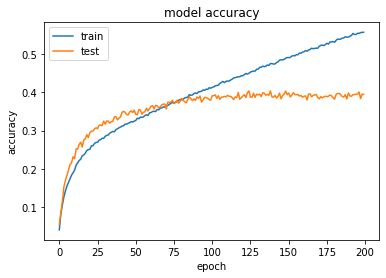

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

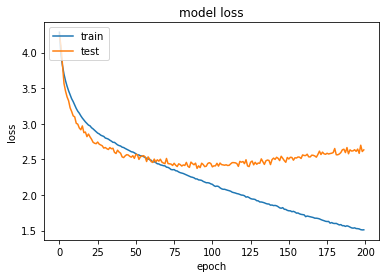

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
from keras.datasets import cifar100
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_test = x_test.astype('float32')
x_test = x_test / 255.0
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
y_pred=pd.DataFrame(y_pred)
y_test=pd.DataFrame(y_test)

p=precision_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
r=recall_score(y_test,y_pred,average='micro',labels=np.unique(y_pred))
print('Precision Is:',p)
print('Recall Is:',r)

Precision Is: 0.4081877545134968
Recall Is: 0.3946
